In [29]:
import numpy as np
import warnings
import pandas as pd
import osmnx as ox
import networkx as nx
import folium
from itertools import product 
from itertools import permutations


In [33]:
#np.random.seed(72)
# Define the parameters for the random distribution
mean_blood, variance_blood = 100, 100
mean_med, variance_med = 45, 12
mean_fuel, variance_fuel = 20, 5

# Generate the random values for each column
column1 = np.random.normal(mean_blood, np.sqrt(variance_blood), 5)
column2 = np.random.normal(mean_med, np.sqrt(variance_med), 5)
column3 = np.random.normal(mean_fuel, np.sqrt(variance_fuel), 5)

demand_df = pd.DataFrame(np.column_stack((column1, column2, column3)).astype(int),
                         columns=['Blood', 'Medication', 'Fuel'],
                         index=['RC 1', 'RC 2', 'RC 3', 'RC 4', 'RC 5'])


coordinates = {'Relief centre': ['Gonguan', 'Taipei Heping Basketball Gymnasium ', 'Taipei Main Library', 'Fullon Hotel', 'Rongjin Gorgeous Time','Taipei Fushing Private School','Linjiang Nightmarket','Linguang Station', 'National Taipei University of Technology'], 
    'Longitute ': [25.014481260127013, 25.02180311329413, 25.029442179830752, 25.036937240691525, 25.030588302088198, 25.039737976324897,25.029476408117134, 25.01845181998901, 25.044099723807577],
    'Latitute': [121.53507124787315, 121.54592265342197, 121.53844937742785, 121.537978882258, 121.52653798040829, 121.54754861724803, 121.55446331070219, 121.55888474410452, 121.53498661688229]}



df = pd.DataFrame(coordinates) 

#combination = product(df["Longitute "], df['Latitute'])
relief_center_permutations = list(permutations(df["Relief centre"],2))

combinations = pd.DataFrame([(rc1, rc2,
                            df.loc[df["Relief centre"] == rc1, "Longitute "].values[0],
                            df.loc[df["Relief centre"] == rc1, "Latitute"].values[0],
                            df.loc[df["Relief centre"] == rc2, "Longitute "].values[0],
                            df.loc[df["Relief centre"] == rc2, "Latitute"].values[0]) for rc1, rc2 in relief_center_permutations],
                          columns=['Relief Center 1', 'Relief Center 2', 'Longitude 1', 'Latitude 1', 'Longitude 2', 'Latitude 2'])
relief_center_numbers = {rc: i for i, rc in enumerate(df['Relief centre'].unique(), start=1)}
combinations['Relief Center 1 Number'] = combinations['Relief Center 1'].map(relief_center_numbers)
combinations['Relief Center 2 Number'] = combinations['Relief Center 2'].map(relief_center_numbers)

#print(combinations)
#len(combinations)
print(demand_df)
display(combinations)

      Blood  Medication  Fuel
RC 1     96          49    17
RC 2     93          36    23
RC 3    101          36    19
RC 4     99          36    19
RC 5     93          50    24


,Relief Center 1,Relief Center 2,Longitude 1,Latitude 1,Longitude 2,Latitude 2,Relief Center 1 Number,Relief Center 2 Number
0,Gonguan,Taipei Heping Basketball Gymnasium,25.014481,121.535071,25.021803,121.545923,1,2
1,Gonguan,Taipei Main Library,25.014481,121.535071,25.029442,121.538449,1,3
2,Gonguan,Fullon Hotel,25.014481,121.535071,25.036937,121.537979,1,4
3,Gonguan,Rongjin Gorgeous Time,25.014481,121.535071,25.030588,121.526538,1,5
4,Gonguan,Taipei Fushing Private School,25.014481,121.535071,25.039738,121.547549,1,6
...,...,...,...,...,...,...,...,...
67,National Taipei University of Technology,Fullon Hotel,25.044100,121.534987,25.036937,121.537979,9,4
68,National Taipei University of Technology,Rongjin Gorgeous Time,25.044100,121.534987,25.030588,121.526538,9,5
69,National Taipei University of Technology,Taipei Fushing Private School,25.044100,121.534987,25.039738,121.547549,9,6
70,National Taipei University of Technology,Linjiang Nightmarket,25.044100,121.534987,25.029476,121.554463,9,7


In [5]:
combinations.to_csv("combinations.csv")
demand_df.to_csv("demand.csv")

In [14]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

routes =[]

# Replace this with the location (address, city, or coordinates) you're interested in
location_name = "Daan, Taipei, Taiwan"
graph = ox.graph_from_place(location_name, network_type="all")

# Assuming 'combinations' is defined somewhere in your code

results = []

### Add edge speeds to the graph
ox.speed.add_edge_speeds(graph, hwy_speeds=None, fallback=None, precision=None, agg=np.mean)

# Replace NaN values with a default speed of 28.5 km/h
#for u, v, data in graph.edges(data=True):
 #   if 'speed' not in data or pd.isna(data['speed']):
  #      graph[u][v][0]['speed'] = 28.5

default_speed= 28.5

####
for i in range(len(combinations)):
#for i in range(1):
    try:
        # Replace these coordinates with the start and end points of your desired routes
        origin_point = (combinations.loc[i, 'Longitude 1'], combinations.loc[i, 'Latitude 1'])
        destination_point = (combinations.loc[i, 'Longitude 2'], combinations.loc[i, 'Latitude 2'])

        # Find the nearest network nodes to the specified coordinates
        origin_node = ox.distance.nearest_nodes(graph, origin_point[1], origin_point[0])
        destination_node = ox.distance.nearest_nodes(graph, destination_point[1], destination_point[0])

        # Function to calculate lanes and lengths for a given path
        def calculate_lanes_lengths(path):
            total_product_lanes_lengths = 0
            total_length = 0

            for i in range(len(path)-1):
                edge_attributes = ox.graph_to_gdfs(graph, nodes=False, edges=True).loc[
                    (path[i], path[i + 1])
                ]
                length = edge_attributes["length"].values[0]

                # Replace NaN or missing 'lanes' attribute with default value "1"
                lanes = edge_attributes["lanes"].fillna(1).values

                # Handle the case where 'lanes' is a list
                if any(isinstance(lane, list) for lane in lanes):
                    lanes = [item for sublist in lanes for item in sublist]

                if len(lanes) > 0:
                    lanes = max(map(int, lanes))  # Convert each element to int before finding the maximum
                else:
                    lanes = 1  # Default value if "lanes" is not available

                total_product_lanes_lengths += lanes * length
                total_length += length

            return total_product_lanes_lengths, total_length

        # Find the shortest path using NetworkX
        shortest_path = nx.shortest_path(graph, source=origin_node, target=destination_node, weight="length")

        # Calculate lanes and lengths for the shortest path
        total_product_lanes_lengths_shortest, total_length_shortest = calculate_lanes_lengths(shortest_path)

        # Print the result for the shortest path
       # print(f"Average lanes per unit length for the shortest path: {total_product_lanes_lengths_shortest / total_length_shortest} lanes/meter")
########
#        average_speed_shortest = np.mean([data['speed'] for u, v, data in graph.edges(data=True) if (u, v) in zip(shortest_path, shortest_path[1:])])
########

        graph_copy = graph.copy()
        for u, v in zip(shortest_path, shortest_path[1:]):
            graph_copy[u][v][0]['length'] = float('inf')

# Find the second shortest path using Dijkstra's algorithm on the modified graph
        second_shortest_path = nx.shortest_path(graph_copy, source=origin_node, target=destination_node, weight="length")

#        average_speed_second = np.mean([data['speed'] for u, v, data in graph.edges(data=True) if (u, v) in zip(second_shortest_path, second_shortest_path[1:])])

        for u, v in zip(second_shortest_path, second_shortest_path[1:]):
            graph_copy[u][v][0]['length'] = float('inf')

        # Find the third shortest path using Dijkstra's algorithm on the modified graph
        third_shortest_path = nx.shortest_path(graph_copy, source=origin_node, target=destination_node, weight="length")

        # Calculate lanes and lengths for the third shortest path
        total_product_lanes_lengths_third, total_length_third = calculate_lanes_lengths(third_shortest_path)
        average_lanes_per_unit_length_third = total_product_lanes_lengths_third / total_length_third

        #average_speed_third = np.mean([data['speed'] for u, v, data in graph.edges(data=True) if (u, v) in zip(third_shortest_path, third_shortest_path[1:])])
       # average_speed_third = np.mean([data.get('speed', default_speed) for u, v, data in graph.edges(data=True) if (u, v) in zip(third_shortest_path, third_shortest_path[1:])])


        # Calculate lanes and lengths for the second shortest path
        total_product_lanes_lengths_second, total_length_second = calculate_lanes_lengths(second_shortest_path)
        total_product_lanes_lengths_shortest, total_length_shortest = calculate_lanes_lengths(shortest_path)
        total_product_lanes_lengths_third, total_length_third = calculate_lanes_lengths(third_shortest_path)
        average_lanes_per_unit_length_shortest = total_product_lanes_lengths_shortest / total_length_shortest
        average_lanes_per_unit_length_second = total_product_lanes_lengths_second / total_length_second
        average_lanes_per_unit_length_third = total_product_lanes_lengths_third / total_length_third



        results.append({
    'Combination': i,
    'Shortest Path - Average Lanes per Unit Length': average_lanes_per_unit_length_shortest,
    'Shortest Path - Total Length': total_length_shortest,
    #'Shortest Path - Average Speed': average_speed_shortest,
    'Second Shortest Path - Average Lanes per Unit Length': average_lanes_per_unit_length_second,
    'Second Shortest Path - Total Length': total_length_second,
    #'Second Shortest Path - Average Speed': average_speed_second,
    'Shortest Path - Nodes': shortest_path,
    'Second Shortest Path - Nodes': second_shortest_path,
    'Third Shortest Path - Average Lanes per Unit Length': average_lanes_per_unit_length_third,
    'Third Shortest Path - Total Length': total_length_third,
    #'Third Shortest Path - Average Speed': average_speed_third,
    'Relief Center 1': combinations.loc[i, 'Relief Center 1'],
    'Relief Center 2': combinations.loc[i, 'Relief Center 2'],
    'Relief Center 1': combinations.loc[i, 'Relief Center 1 Number'],
    'Relief Center 2': combinations.loc[i, 'Relief Center 2 Number'],
    
})


        print(f"Iteration {i}")


        
        routes.append(shortest_path)
        routes.append(second_shortest_path)
        routes.append(third_shortest_path)

    except nx.NetworkXNoPath:
        # Handle the case where no path is found
        
        print(f"No path found for combination {i}. Continuing with the next combination.")
        continue

# Convert the list of results to a DataFrame
df_results = pd.DataFrame(results)

# Print or further process the DataFrame
print(df_results)



Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
    Combination  Shortest Path - Average Lanes per Unit Length  \
0       

In [16]:
df_results.to_csv("paths.csv")

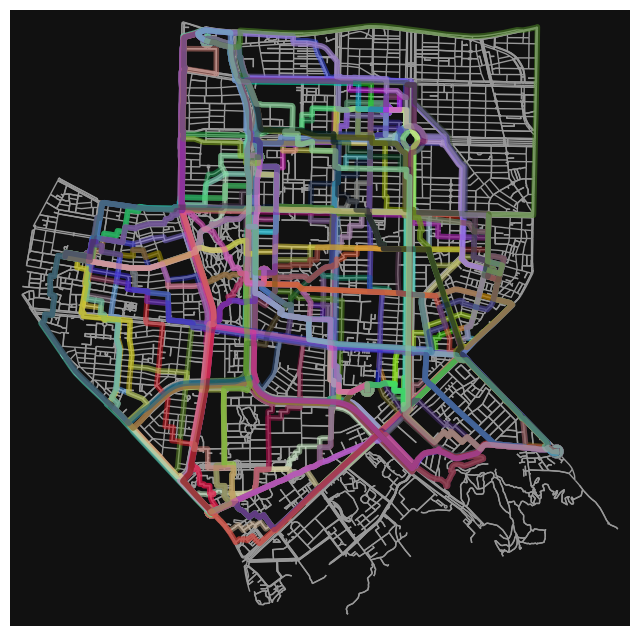

In [48]:
warnings.filterwarnings("ignore", category=UserWarning, module="osmnx.plot")
rc = random_colors = [tuple(np.random.rand(3)) for _ in range(len(routes))]
ox.plot_graph_routes(graph, routes, route_colors=rc, route_linewidth=0, node_size=0)



/Users/davidnovak/Documents/Uni/NTU/Operations Research/Assignments/assignment_02